In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import dill
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import os
from pathlib import Path
import consts as C
import ipywidgets as widgets

from os import listdir
from os.path import isfile, join
import brian2 as b2
import datetime
from cochleas.anf_utils import load_anf_response
from cochleas.anf_response import AnfResponse
import brian2hears as b2h

2024-08-08 11:23:48,486 [INFO ]  

>>>>> start execution


In [2]:
results_dir = Path(os.getcwd()) / Path(C.Paths.RESULTS_DIR)

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (8, 3)
print(results_dir)

/home/paolo/Documents/school/master/polimi/thesis/polithesis/src/../results


In [3]:
# def draw_tone_vs_ANF(data, angle):
#     input = data["basesound"]
#     cochlea_key = data["conf"]["cochlea_type"]
#     anf: AnfResponse = load_anf_response(input, angle, cochlea_key)

#     ihf_most_spikes = (None, 0)
#     for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items():
#         if len(spike_times) > ihf_most_spikes[1]:
#             ihf_most_spikes = (ihf_idx, len(spike_times))
#     ihf_spikes = [
#         len(spike_times)
#         for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items()
#     ]
#     print(
#         f"the IHF 'spiking' at highest frequency is n.{ihf_most_spikes[0]}, spikes {ihf_most_spikes[1]}/s"
#     )
#     # plt.plot(ihf_spikes)
#     # plt.show()

#     print(anf.binaural_anf_spiketrain["L"][1241])
#     # plt.scatter(
#     #     anf.binaural_anf_spiketrain["L"][1241] / b2.second,
#     #     [1] * len(anf.binaural_anf_spiketrain["L"][1241]),
#     # )


# result_file = "tone_1.kHz_70dB&realistic_subj1002&inh_model&default_params&2024-08-02T19:37:28.pic"
# # result_file = "tone_1.kHz_70dB&ppg&inh_model&default_params&2024-08-02T19:56:40.pic"
# angle = 90
# with open(join(results_dir, result_file), "rb") as f:
#     res = dill.load(f, ignore=True)
#     draw_tone_vs_ANF(res, angle)

2024-08-08 11:30:29,021 [INFO ]  generating simulated IHC response...
2024-08-08 11:30:39,995 [INFO ]  generation complete.
the IHF 'spiking' at highest frequency is n.1129, spikes 340/s
plotting all IHF with corresponding total spike count


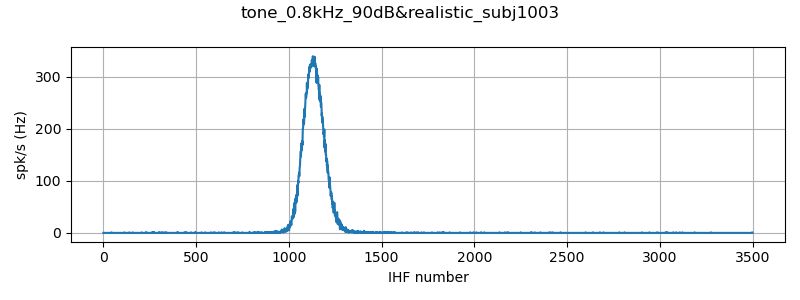

In [8]:
from utils.custom_sounds import Tone
from cochleas.RealisticCochlea import sound_to_spikes
from cochleas.anf_utils import create_sound_key

freq = 0.8 * b2.kHz
tone = Tone(freq)
level = 90
angle = -90
cochlea_key = "realistic_subj1003"
ex_key = f"{create_sound_key(tone)}&{cochlea_key}"

tone.sound.level = level * b2h.dB
anf = sound_to_spikes(tone, angle, False)
ihf_most_spikes = (None, 0)
for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items():
    if len(spike_times) > ihf_most_spikes[1]:
        ihf_most_spikes = (ihf_idx, len(spike_times))
ihf_spikes = [
    len(spike_times)
    for ihf_idx, spike_times in anf.binaural_anf_spiketrain["L"].items()
]
print(
    f"the IHF 'spiking' at highest frequency is n.{ihf_most_spikes[0]}, spikes {ihf_most_spikes[1]}/s"
)
fig = plt.figure()
fig.suptitle(ex_key)
plt.plot(ihf_spikes)
plt.xlabel("IHF number")
plt.ylabel("spk/s (Hz)")
print("plotting all IHF with corresponding total spike count")
fig.tight_layout()
plt.show()

{'spikest_ihf_left': 1129, 'spikest_ihf_right': 1126, 'num_left': 340, 'num_right': 144}
[31.67800454 * msecond, 40.56689342 * msecond, 46.53061224 * msecond, 51.67800454 * msecond, 55.69160998 * msecond, 64.48979592 * msecond, 75.41950113 * msecond]


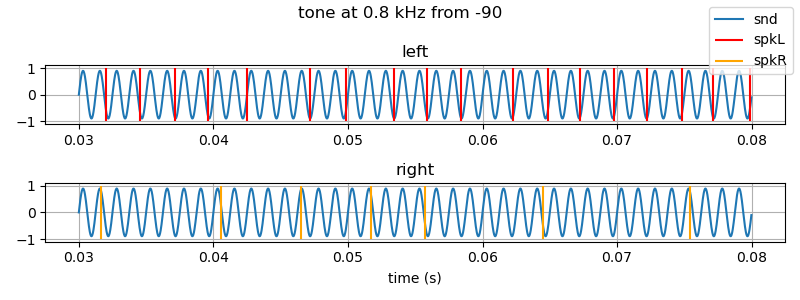

In [11]:
from sorcery import dict_of
from brian2 import ms, second
from math import inf

plt.close()

range = slice(30 * ms, 80 * ms)

anf_left, anf_right = (
    anf.binaural_anf_spiketrain["L"],
    anf.binaural_anf_spiketrain["R"],
)
spikest_ihf_left, _ = max(anf_left.items(), key=lambda x: len(set(x[1] / ms)))
spikest_ihf_right, _ = max(anf_right.items(), key=lambda x: len(set(x[1] / ms)))
print(
    dict_of(
        spikest_ihf_left,
        spikest_ihf_right,
        num_left=len(anf_left[spikest_ihf_left]),
        num_right=len(anf_right[spikest_ihf_right]),
    )
)

input = tone.sound
fig, [left, right] = plt.subplots(2, 1)

def select_in_range(full,spikest): 
    return [i for i in full[spikest] if i >= range.start and i < range.stop]

spikest_anf_left_in_range = select_in_range(anf_left,spikest_ihf_right)
spikest_anf_right_in_range = select_in_range(anf_right,spikest_ihf_right)

print(spikest_anf_right_in_range)

fig.suptitle(f"tone at {freq} from {angle}")
left.plot(input[range].times + range.start, input[range], label="snd")
left.vlines(spikest_anf_left_in_range, -1, 1, colors='r', label="spkL")
left.set_title("left")
right.plot(input[range].times + range.start, input[range])
right.vlines(spikest_anf_right_in_range,-1,1, colors='orange', label="spkR")
right.set_title("right")
right.set_xlabel('time (s)')
fig.legend()
fig.tight_layout()